In [40]:
# Importar funciones del paquete
from ECG_Functions import (Cargar_Ecg, Removedor_DC, Detectar_picos_R_AIP, Graficar_ecg_detallado, Graficar_regiones_ecg, Matriz_De_Confusion, Metricas)



In [41]:
# Notebook: Documentación de funciones y ejemplos
"""
Objetivo: Este notebook muestra cómo usar las funciones principales del paquete `ECG_Functions`.
Cada sección explica una función, qué hace (resumen), parámetros clave y un ejemplo de uso.
"""


'\nObjetivo: Este notebook muestra cómo usar las funciones principales del paquete `ECG_Functions`.\nCada sección explica una función, qué hace (resumen), parámetros clave y un ejemplo de uso.\n'

In [42]:
# Listar variables dentro del archivo ecg.mat para decidir cuál usar
mat_path = 'ecg.mat'
if not os.path.exists(mat_path):
    print('Archivo ecg.mat no encontrado en la raíz del proyecto:', os.getcwd())
else:
    vars_in_mat = sio.whosmat(mat_path)
    print('Variables en ecg.mat (name, shape):')
    for v in vars_in_mat:
        print(v)

Variables en ecg.mat (name, shape):
('ecg_lead', (1129116, 1), 'double')
('qrs_pattern1', (113, 1), 'double')
('heartbeat_pattern1', (411, 1), 'double')
('heartbeat_pattern2', (441, 1), 'double')
('qrs_detections', (1903, 1), 'double')


In [43]:
# Cargar_Ecg: carga señales desde `.mat` o registros WFDB
"""
Qué hace:
- Lee un archivo .mat (o registro WFDB `.hea/.dat`) y devuelve:
  - `ecg_one_lead`: arreglo 1D con la señal ECG de la derivación seleccionada
  - `picos_reales`: (opcional) vector con picos marcados en el .mat
  - `cant_muestras`: número total de muestras de la señal

Parámetros clave:
- `nombre_archivo`: ruta al archivo .mat o registro WFDB
- `val`: nombre de la variable dentro del .mat que contiene la señal
- `lead`: índice de derivación a extraer (ej.: `lead=0` para la primera derivación)
- `qrs_detections`: nombre de la variable con detecciones reales en el .mat (si existe)

Ejemplo de uso:
```python
# Archivo `ecg.mat` debe tener la variable `ecg_lead` y opcionalmente `qrs_detections`
ecg_one_lead, picos_reales, cant_muestras = Cargar_Ecg('ecg.mat', val='ecg_lead', lead=None, qrs_detections='qrs_detections')
print('Muestras:', cant_muestras)
print('Picos reales disponibles:', picos_reales is not None)
```
"""


"\nQué hace:\n- Lee un archivo .mat (o registro WFDB `.hea/.dat`) y devuelve:\n  - `ecg_one_lead`: arreglo 1D con la señal ECG de la derivación seleccionada\n  - `picos_reales`: (opcional) vector con picos marcados en el .mat\n  - `cant_muestras`: número total de muestras de la señal\n\nParámetros clave:\n- `nombre_archivo`: ruta al archivo .mat o registro WFDB\n- `val`: nombre de la variable dentro del .mat que contiene la señal\n- `lead`: índice de derivación a extraer (ej.: `lead=0` para la primera derivación)\n- `qrs_detections`: nombre de la variable con detecciones reales en el .mat (si existe)\n\nEjemplo de uso:\n```python\n# Archivo `ecg.mat` debe tener la variable `ecg_lead` y opcionalmente `qrs_detections`\necg_one_lead, picos_reales, cant_muestras = Cargar_Ecg('ecg.mat', val='ecg_lead', lead=None, qrs_detections='qrs_detections')\nprint('Muestras:', cant_muestras)\nprint('Picos reales disponibles:', picos_reales is not None)\n```\n"

In [44]:
# Cargar la señal usando la función Cargar_Ecg; intentar usar 'ecg_lead' y 'qrs_detections' como nombres comunes
valname = 'ecg_lead'
qrs_name = 'qrs_detections'
try:
    ecg_one_lead, picos_reales, cant_muestras = Cargar_Ecg(mat_path, val=valname, lead=None, qrs_detections=qrs_name)
    print('Se cargó ecg.lead con forma', ecg_one_lead.shape)
    if picos_reales is None:
        print('No se encontró variable qrs_detections en el archivo .mat — picos reales no disponibles')
    else:
        print('Picos reales cargados:', picos_reales.shape)
except Exception as e:
    print('Error al cargar el archivo ecg.mat:', str(e))
    # Intentar inferir alternativas si la carga inicial falla
    print("Intentando cargar la primera variable encontrada en el .mat como señal...")
    mat_struct = sio.loadmat(mat_path)
    keys = [k for k in mat_struct.keys() if not k.startswith('__')]
    if not keys:
        raise RuntimeError('No se encontraron variables útiles en el .mat')
    alt_key = keys[0]
    print('Usando variable:', alt_key)
    ecg_one_lead = np.asarray(mat_struct[alt_key]).flatten()
    picos_reales = mat_struct.get(qrs_name, None)
    picos_reales = np.asarray(picos_reales).flatten() if picos_reales is not None else None
    cant_muestras = len(ecg_one_lead)

Se cargó ecg.lead con forma (1129116,)
Picos reales cargados: (1903,)


Número de muestras: 1129116


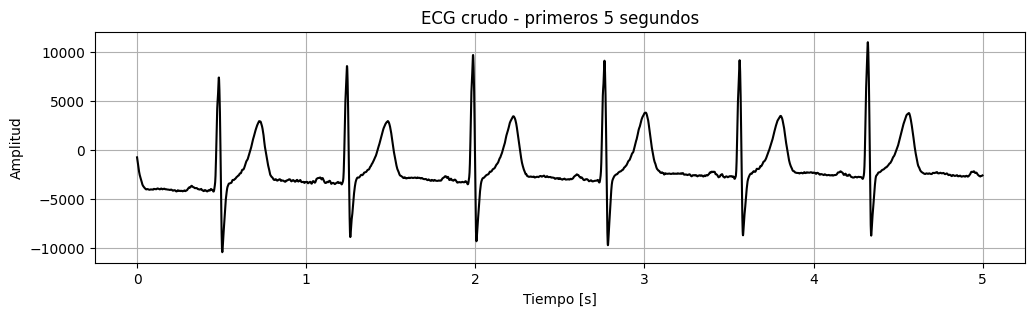

In [45]:
# Mostrar información básica y graficar un segmento de la señal cruda
fs = 1000.0  # frecuencia de muestreo por defecto
print('Número de muestras:', cant_muestras)
t = np.arange(cant_muestras) / fs

# Graficar segmento de 5 segundos si hay suficientes muestras
seg_seconds = 5
seg_samples = int(seg_seconds * fs)
end_idx = min(cant_muestras, seg_samples)

plt.figure(figsize=(12, 3))
plt.plot(t[:end_idx], ecg_one_lead[:end_idx], color='k')
plt.title('ECG crudo - primeros {:d} segundos'.format(seg_seconds))
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

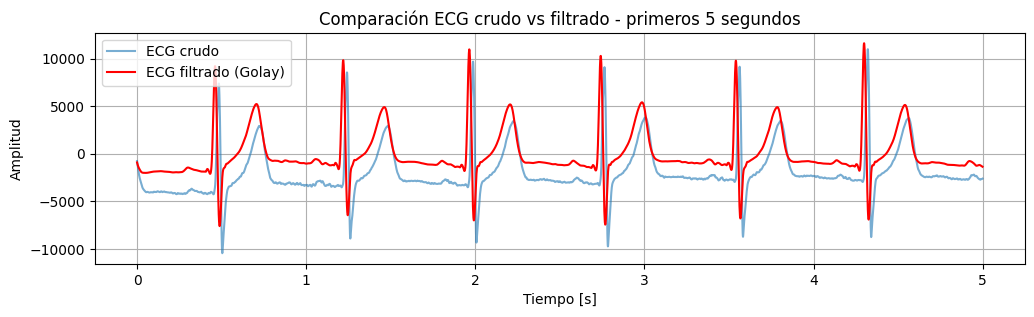

In [46]:
# Aplicar Removedor_DC para suavizar la señal y graficar la comparación
ecg_filtered = Removedor_DC(ecg_one_lead, D=64, N=20, window_length=101, polyorder=9)
plt.figure(figsize=(12, 3))
plt.plot(t[:end_idx], ecg_one_lead[:end_idx], label='ECG crudo', alpha=0.6)
plt.plot(t[:end_idx], ecg_filtered[:end_idx], label='ECG filtrado (Golay)', color='red')
plt.title('Comparación ECG crudo vs filtrado - primeros {:d} segundos'.format(seg_seconds))
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Removedor_DC: remover componente DC y suavizar (Savitzky-Golay)
"""
Qué hace:
- Aplica un filtro diseñado para eliminar la componente de corriente continua (DC)
  y después suaviza la señal con Savitzky-Golay.
- Parámetros importantes:
  - `D`, `N`: definen la respuesta del filtro FIR/IIR
  - `window_length`, `polyorder`: parámetros del filtro Savitzky-Golay

Ejemplo de uso:
```python
# ecg_one_lead es la señal simple recuperada por Cargar_Ecg
ecg_filtered = Removedor_DC(ecg_one_lead, D=64, N=20, window_length=101, polyorder=9)
# Mostrar los primeros 10 valores para comprobar la operación:
print('Primeros 10 valores original:', ecg_one_lead[:10])
print('Primeros 10 valores filtrado:', ecg_filtered[:10])
```
"""


"\nQué hace:\n- Aplica un filtro diseñado para eliminar la componente de corriente continua (DC)\n  y después suaviza la señal con Savitzky-Golay.\n- Parámetros importantes:\n  - `D`, `N`: definen la respuesta del filtro FIR/IIR\n  - `window_length`, `polyorder`: parámetros del filtro Savitzky-Golay\n\nEjemplo de uso:\n```python\n# ecg_one_lead es la señal simple recuperada por Cargar_Ecg\necg_filtered = Removedor_DC(ecg_one_lead, D=64, N=20, window_length=101, polyorder=9)\n# Mostrar los primeros 10 valores para comprobar la operación:\nprint('Primeros 10 valores original:', ecg_one_lead[:10])\nprint('Primeros 10 valores filtrado:', ecg_filtered[:10])\n```\n"

Número de picos detectados: 1904


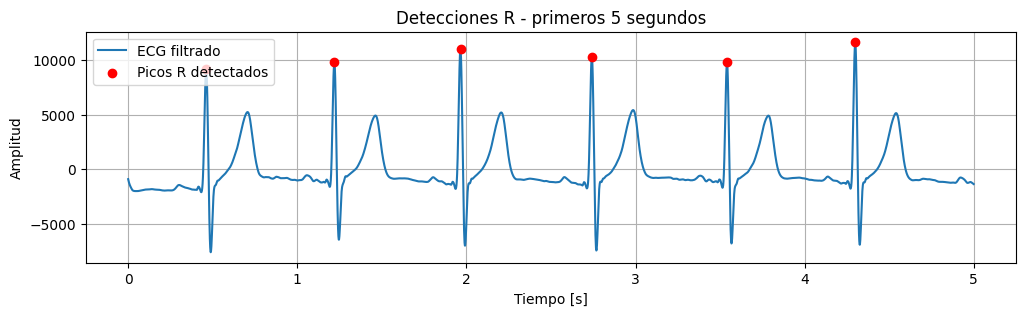

In [48]:
# Detectar picos R con Detectar_picos_R_AIP y graficar detecciones
peaks_R = Detectar_picos_R_AIP(ecg_filtered, fs=fs, percentile=30, trgt_width=0.09, trgt_min_pattern_separation=0.3)
print('Número de picos detectados:', len(peaks_R))

plt.figure(figsize=(12, 3))
plt.plot(t[:end_idx], ecg_filtered[:end_idx], label='ECG filtrado')
peaks_in_seg = [p for p in peaks_R if p < end_idx]
if peaks_in_seg:
    plt.scatter(np.array(peaks_in_seg)/fs, ecg_filtered[peaks_in_seg], c='r', zorder=3, label='Picos R detectados')
plt.title('Detecciones R - primeros {:d} segundos'.format(seg_seconds))
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Detectar_picos_R_AIP: detección de picos R usando plantilla AIP
"""
Qué hace:
- Detecta picos R en una señal ECG filtrada usando un detector impulsivo/pseudoperiódico.
- Operación: crea un patrón gaussiano derivado, aplica filtrado, suaviza y aplica umbral basado en percentil.

Parámetros clave:
- `fs`: frecuencia de muestreo en Hz (necesario para convertir tiempos a muestras)
- `percentile`: umbral relativo (percentil) en la señal procesada para detectar picos
- `trgt_width`: ancho objetivo del patrón (s)
- `trgt_min_pattern_separation`: separación mínima entre latidos detectados (s)

Ejemplo de uso:
```python
# La señal ecg_filtered y la frecuencia fs ya están definidas en el notebook
peaks_R = Detectar_picos_R_AIP(ecg_filtered, fs=fs, percentile=30, trgt_width=0.09, trgt_min_pattern_separation=0.3)
print('Cantidad de picos detectados:', len(peaks_R))
print('Picos (primeros 10):', peaks_R[:10])
```
Consejos:
- Si detectas falsas detecciones: intenta aumentar `percentile` o `trgt_min_pattern_separation`.
- Si faltan detecciones, reduce `percentile` o `trgt_min_pattern_separation`.
"""


"\nQué hace:\n- Detecta picos R en una señal ECG filtrada usando un detector impulsivo/pseudoperiódico.\n- Operación: crea un patrón gaussiano derivado, aplica filtrado, suaviza y aplica umbral basado en percentil.\n\nParámetros clave:\n- `fs`: frecuencia de muestreo en Hz (necesario para convertir tiempos a muestras)\n- `percentile`: umbral relativo (percentil) en la señal procesada para detectar picos\n- `trgt_width`: ancho objetivo del patrón (s)\n- `trgt_min_pattern_separation`: separación mínima entre latidos detectados (s)\n\nEjemplo de uso:\n```python\n# La señal ecg_filtered y la frecuencia fs ya están definidas en el notebook\npeaks_R = Detectar_picos_R_AIP(ecg_filtered, fs=fs, percentile=30, trgt_width=0.09, trgt_min_pattern_separation=0.3)\nprint('Cantidad de picos detectados:', len(peaks_R))\nprint('Picos (primeros 10):', peaks_R[:10])\n```\nConsejos:\n- Si detectas falsas detecciones: intenta aumentar `percentile` o `trgt_min_pattern_separation`.\n- Si faltan detecciones, 

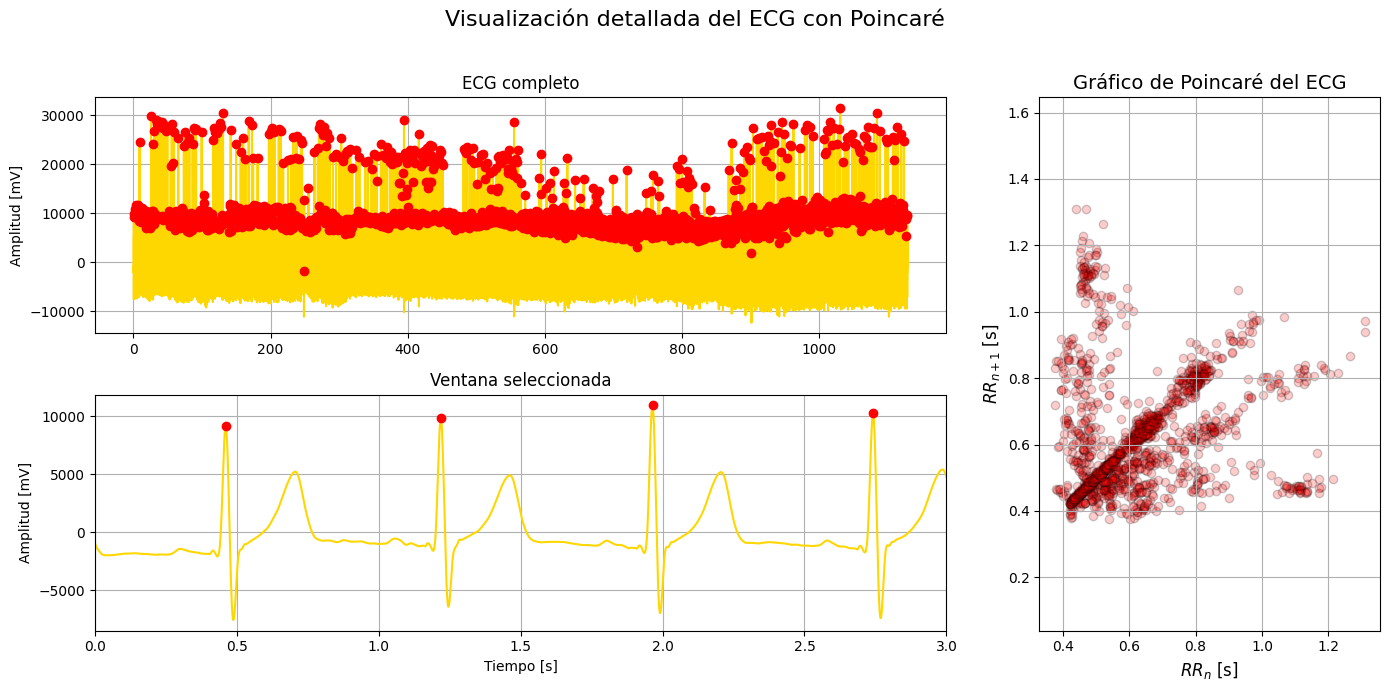

In [50]:
# Visualización detallada con Poincaré (puede abrir ventanas interactivas si se usa 'matplotlib notebook')
try:
    Graficar_ecg_detallado(ecg_filtered, peaks_R, fs=fs)
except Exception as e:
    print('La función interactiva Graficar_ecg_detallado pudo haber fallado en cabeza del notebook:', e)
    print('Intenta ejecutarla desde un entorno con GUI o cambiar el backend de Matplotlib a notebook interactivo: %matplotlib notebook')

In [51]:
# Funciones de visualización: Graficar_regiones_ecg y Graficar_ecg_detallado
"""
Graficar_regiones_ecg:
- Muestra ventanas/regiones seleccionadas de la señal (original y filtrada).
- Parámetros: `regs_interes` debe ser lista/array de sub-ventanas (inicio, fin en muestras).
- Útil para inspeccionar segmentos concretos con BPM calculado en la ventana.

Ejemplo:
```python
# Definir una ventana de interés (ej.: 2 a 7 segundos) y convertir a muestras
start_s, end_s = 2, 7
regs = [[int(start_s * fs), int(end_s * fs)]]
Graficar_regiones_ecg(ecg_one_lead, ecg_filtered, peaks_R, regs, fs_ECG=fs)
```

Graficar_ecg_detallado:
- Muestra figura con vista completa del ECG, una ventana seleccionable y gráfico de Poincaré de RR.
- Si deseas interacción en el notebook, prueba `%matplotlib notebook` para poder usar `SpanSelector`.
- Toma `ecg`, `peaks_R` y `fs` como entradas.

Ejemplo:
```python
# Muestra una visualización con Poincaré
Graficar_ecg_detallado(ecg_filtered, peaks_R, fs=fs)
```
"""


'\nGraficar_regiones_ecg:\n- Muestra ventanas/regiones seleccionadas de la señal (original y filtrada).\n- Parámetros: `regs_interes` debe ser lista/array de sub-ventanas (inicio, fin en muestras).\n- Útil para inspeccionar segmentos concretos con BPM calculado en la ventana.\n\nEjemplo:\n```python\n# Definir una ventana de interés (ej.: 2 a 7 segundos) y convertir a muestras\nstart_s, end_s = 2, 7\nregs = [[int(start_s * fs), int(end_s * fs)]]\nGraficar_regiones_ecg(ecg_one_lead, ecg_filtered, peaks_R, regs, fs_ECG=fs)\n```\n\nGraficar_ecg_detallado:\n- Muestra figura con vista completa del ECG, una ventana seleccionable y gráfico de Poincaré de RR.\n- Si deseas interacción en el notebook, prueba `%matplotlib notebook` para poder usar `SpanSelector`.\n- Toma `ecg`, `peaks_R` y `fs` como entradas.\n\nEjemplo:\n```python\n# Muestra una visualización con Poincaré\nGraficar_ecg_detallado(ecg_filtered, peaks_R, fs=fs)\n```\n'

In [52]:
# Si existen picos reales, calcular la matriz de confusión y métricas
if picos_reales is not None:
    VP, VN, FP, FN, conf = Matriz_De_Confusion(peaks_R, picos_reales, tol=30, cant_muestras=cant_muestras)
    precision, recall, f1, acc = Metricas(conf)
    print('Confusion matrix:')
    print(conf)
    print("Metrics:")
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'Accuracy: {acc:.4f}')
else:
    print('No hay picos reales disponibles en el dataset para calcular métricas.')

Confusion matrix:
[[   1901       3]
 [      2 1127210]]
Metrics:
Precision: 0.9984
Recall: 0.9989
F1-score: 0.9987
Accuracy: 1.0000


In [53]:
# Matriz_De_Confusion y Metricas: evaluación de detección
"""
Matriz_De_Confusion:
- Compara detecciones `peaks_R` contra picos reales `true_peaks` con una tolerancia `tol` en muestras.
- Devuelve indices de VP, VN_count, FP, FN y la matriz de confusión en formato [[TP, FP],[FN, TN]].

Metricas:
- Calcula precision, recall, f1 y accuracy a partir de la matriz de confusión.

Ejemplo de uso:
```python
# Asumiendo que `peaks_R` y `picos_reales` están definidos:
VP, VN, FP, FN, conf = Matriz_De_Confusion(peaks_R, picos_reales, tol=int(0.03*fs), cant_muestras=cant_muestras)
precision, recall, f1, acc = Metricas(conf)
print('Confusion matrix:', conf)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)
print('Accuracy:', acc)
```
Consejo: la tolerancia `tol` se recomienda en torno a 20-50 ms (ej.: `int(0.03*fs)` para 30 ms en fs=1000Hz).
"""


"\nMatriz_De_Confusion:\n- Compara detecciones `peaks_R` contra picos reales `true_peaks` con una tolerancia `tol` en muestras.\n- Devuelve indices de VP, VN_count, FP, FN y la matriz de confusión en formato [[TP, FP],[FN, TN]].\n\nMetricas:\n- Calcula precision, recall, f1 y accuracy a partir de la matriz de confusión.\n\nEjemplo de uso:\n```python\n# Asumiendo que `peaks_R` y `picos_reales` están definidos:\nVP, VN, FP, FN, conf = Matriz_De_Confusion(peaks_R, picos_reales, tol=int(0.03*fs), cant_muestras=cant_muestras)\nprecision, recall, f1, acc = Metricas(conf)\nprint('Confusion matrix:', conf)\nprint('Precision:', precision)\nprint('Recall:', recall)\nprint('F1:', f1)\nprint('Accuracy:', acc)\n```\nConsejo: la tolerancia `tol` se recomienda en torno a 20-50 ms (ej.: `int(0.03*fs)` para 30 ms en fs=1000Hz).\n"

## Notas de cierre y ajustes
- Si el archivo `.mat` no tiene la variable `ecg_lead`, el notebook intenta cargar la primera variable disponible.
- Ajusta `percentile` y `trgt_min_pattern_separation` en Detectar_picos_R_AIP para mejorar la detección.
- Para interactividad completa con `Graficar_ecg_detallado`, prueba `%matplotlib notebook` o ejecuta el script desde un entorno con GUI.

In [54]:
## Ejemplos rápidos y recomendaciones finales

- Para ejecutar el flujo completo desde la terminal:  
```powershell
python Deteccion_AIP.py --file ecg.mat --varname ecg_lead --lead 0 --fs 1000
```

- Ajustes que suelen mejorar la detección:
  - Aumentar `percentile` si hay muchos falsos positivos.
  - Aumentar `trgt_min_pattern_separation` si hay múltiples detecciones por latido.
  - Ajustar `tol` en `Matriz_De_Confusion` a alrededor de 20-40 ms (int(`0.02*fs`) a int(`0.04*fs`)).

- Notas de rendimiento:
  - El filtrado y la detección son relativamente rápidos en registros de varios minutos.
  - Para grandes lotes, ejecute en un entorno de server o utilice muestra/reduce la tasa de muestreo (`fs`) si es apropiado.


SyntaxError: invalid syntax (2865059863.py, line 3)